In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch
import torch.nn as nn
from torchvision import models
from captum.attr import IntegratedGradients
import numpy as np


c:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Dataset Loader
class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate over files and assign labels based on the filename
        for filename in os.listdir(root_dir):
            if filename.lower().startswith('noncrack'):
                self.image_paths.append(os.path.join(root_dir, filename))
                self.labels.append(0)  # 0 for No Crack
            else:
                self.image_paths.append(os.path.join(root_dir, filename))
                self.labels.append(1)  # 1 for Crack

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Load dataset
dataset = CrackDataset(root_dir='../project2/data/train/images', transform=transform)

In [5]:
# Split data
indices = list(range(len(dataset)))
labels = dataset.labels

# Split indices into train, val, and test (70/15/15)
train_indices, val_indices, train_labels, val_labels = train_test_split(
    indices, labels, test_size=0.2, stratify=labels, random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Load Pre-trained ResNet
model = models.resnet50(pretrained=True)

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 Classes: Crack, No Crack
model.load_state_dict(torch.load("resnet50_6.pth", weights_only=True))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\Василий\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Василий\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Василий\AppData\Roaming\Python\Python311\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyp

In [9]:
from tqdm import tqdm

# Training and Validation Loop
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=1):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
        
        # Validation Phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = correct / total
        print(f"Validation Accuracy: {val_acc:.2f}")
        # if val_acc > 0.98:
        #     break


In [8]:
train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [02:18<00:00,  1.73it/s]


Epoch 1/1, Loss: 0.17733964773041827
Validation Accuracy: 0.96


In [7]:
import matplotlib.pyplot as plt
import skimage

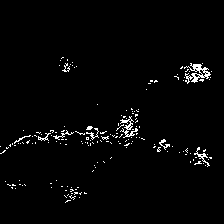

In [8]:
# model = models.resnet18()
# model.load_state_dict(torch.load("resnet50.pth", weights_only=True))

# Take and process
images_path = "../project2/data/train/images/"
masks_path = "../project2/data/train/masks/"
file_path = "CFD_002.jpg"
image_path = images_path + file_path
mask_path = masks_path + file_path

def get_pred(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    pred_class = output.argmax().item()

    if pred_class == 0:
        return np.zeros((448, 448))

    # Get heatmap
    ig = IntegratedGradients(model)
    attr0 = ig.attribute(input_tensor, target=0)
    attr1 = ig.attribute(input_tensor, target=1)
    heatmap = attr1.squeeze() - attr0.squeeze()

    #############
    # Get image #
    #############

    # Map the ranges
    heatmap_min = heatmap.min()
    heatmap_max = heatmap.max()
    heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

    # Threshold and scale
    heatmap = (heatmap > torch.quantile(heatmap, .99)).type(torch.uint8)
    heatmap *= 255
    heatmap = heatmap.type(torch.uint8)

    # PIL input format
    heatmap = torch.permute(heatmap, (1, 2, 0))
    heatmap = heatmap.max(2)[0]
    image = Image.fromarray(heatmap.cpu().numpy())

    return image


im = get_pred(image_path)
im

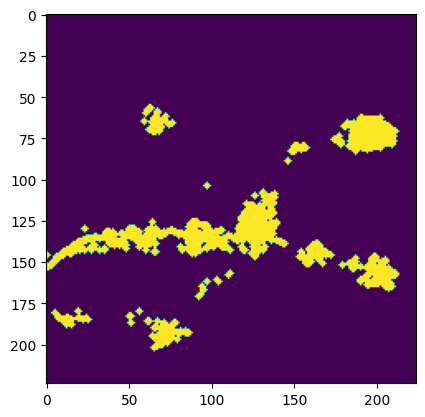

In [9]:
img = np.array(im)


for _ in range(1):
    img = skimage.morphology.dilation(img)
    img = skimage.morphology.closing(img)
    img = skimage.morphology.opening(img)
    img = skimage.morphology.dilation(img)



# for _ in range(2):
#     img = skimage.morphology.dilation(img)

plt.imshow(img)

In [10]:
def calculate_iou_loss(pred, true):
    # Thresholding the images to binary (0 or 1)
    pred_bin = (pred > 0.5).astype(np.int32)
    true_bin = (true > 0.5).astype(np.int32)
    
    # Intersection and Union
    intersection = np.sum(pred_bin & true_bin)
    union = np.sum(pred_bin | true_bin)
    
    # IoU loss
    iou = intersection / union if union != 0 else 1  # Avoid division by zero
    iou_loss = 1 - iou
    return iou_loss


def calculate_dice_loss(pred, true):
    # Thresholding the images to binary (0 or 1)
    pred_bin = (pred > 0.5).astype(np.int32)
    true_bin = (true > 0.5).astype(np.int32)
    
    # Intersection
    intersection = np.sum(pred_bin & true_bin)
    
    # Dice coefficient
    dice = (2 * intersection) / (np.sum(pred_bin) + np.sum(true_bin)) if (np.sum(pred_bin) + np.sum(true_bin)) != 0 else 1  # Avoid division by zero
    dice_loss = 1 - dice
    return dice_loss

In [11]:
images_path = "../project2/data/test/images/"
masks_path = "../project2/data/test/masks/"
n = 10
iou = 0
dice = 0

file_paths = list(os.walk(images_path))[0][2]
np.random.shuffle(file_paths)
file_paths = file_paths[:n]
i = 0
for file_path in file_paths:
    image_path = images_path + file_path
    mask_path = masks_path + file_path
    image = get_pred(image_path)
    resized = skimage.transform.resize(np.array(image), (448, 448), anti_aliasing=False)
    # resized = skimage.morphology.dilation(resized)
    resized = skimage.morphology.closing(resized)
    resized = skimage.morphology.opening(resized)
    resized = skimage.morphology.dilation(resized)
    i += 1
    print(f"{i}/{n}")
    mask = Image.open(mask_path)
    mask = np.array(mask) / 255
    iou += (1 - calculate_iou_loss(resized, mask))
    dice += (1 - calculate_dice_loss(resized, mask))

    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # # Display the first image (resized)
    # axes[0].imshow(resized)
    # axes[0].set_title("Resized Image")
    # axes[0].axis('off')  # Hide the axes for better visualization

    # # Display the second image (mask)
    # axes[1].imshow(mask)
    # axes[1].set_title("Mask Image")
    # axes[1].axis('off')  # Hide the axes for better visualization

    # # Show the combined plot
    # plt.show()

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [12]:
print(f"IOU: {iou / n}")
print(f"Dice: {dice / n}")

IOU: 0.228733964253183
Dice: 0.3132024864379007


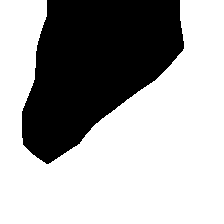

In [26]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image

# Initialize Grad-CAM
target_layer = model.layer4[-1]  # Last layer of ResNet-18
cam = GradCAM(model, target_layers=[target_layer])

# Get the predicted class
output = model(input_tensor)
# class_idx = torch.argmax(output).item()
class_idx = 0

# Generate the CAM
grayscale_cam = cam(input_tensor)
grayscale_cam = grayscale_cam[0]  # Remove batch dimension


# Normalize the CAM to [0, 1]
cam_normalized = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))

# Apply a threshold to create a binary segmentation mask
threshold = 0.2
segmentation_mask = (cam_normalized > threshold).astype(np.uint8) * 255  # Binary mask (0 or 255)

# Resize the mask to match the original image size
segmentation_mask_pil = Image.fromarray(segmentation_mask)
segmentation_mask_pil